# Marathon Training Performance & Recovery Dashboard
### A Data-Driven Approach to Enhance Endurance and Optimize Recovery

## Introduction

### Objective
The Marathon Training Performance & Recovery Dashboard is a comprehensive data analysis tool designed to track, analyze, and visualize key metrics for marathon training. By leveraging interactive visualizations and performance-based insights, this tool empowers runners to optimize their training regimen, prevent overtraining, and achieve peak performance.

### Advanced Features
- **Pace Analysis**: Evaluate trends in running pace over days, weeks, and months to monitor progress.
- **Heart Rate Monitoring**: Visualize heart rate patterns to assess training intensity and cardiovascular efficiency.
- **Performance Metrics**: Generate a custom performance score combining pace, heart rate, and distance for holistic evaluation.
- **Mileage Tracking**: Track cumulative and monthly mileage to ensure gradual progression and prevent injuries.
- **Training Stress Score (TSS)**: Calculate and visualize the intensity of training sessions using duration, pace, and functional threshold power.
- **Load Balancing**: Analyze Acute Training Load (ATL) and Chronic Training Load (CTL) to ensure proper balance between effort and recovery.
- **Interactive Dashboard**: Present data using modern libraries (e.g., Plotly, Dash, Streamlit) for easy interpretation.

### Purpose
This tool was created to:
- Assist in personal marathon training by providing actionable insights into performance and recovery.
- Demonstrate advanced skills in Python, data visualization, and user-friendly dashboard design for professional applications.

### Technology Stack
- **Programming Language**: Python
- **Data Visualization**: Plotly, Matplotlib, Seaborn
- **Interactive Framework**: Dash/Streamlit
- **Data Management**: Pandas, NumPy
- **Deployment**: GitHub Pages

In [60]:
import pandas as pd
import numpy as np
import warnings

# Suppress the SettingWithCopyWarning
warnings.simplefilter("ignore", category=UserWarning)


# Load the CSV data
file_path = 'RunningData.csv' 

try:
    df = pd.read_csv(file_path, header=0)  # First row is used as header
    # print("Preview of raw data:")
    # print(df.head(10))  # Print the first 10 rows to check structure

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Proceed only if the DataFrame is loaded successfully
if df is not None and not df.empty:
    # Clean and process the DataFrame
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()

    # Define the cleaning function for time format
    def clean_time_format(time_str):
        if pd.isna(time_str):
            return time_str  # Return NaN as is
        parts = time_str.split(':')
        # If there are only two components (mm:ss), add "00:" in front
        if len(parts) == 2:
            return f"00:{time_str}"
        # If there are three components (hh:mm:ss), return as is
        return time_str

    # Apply the cleaning function to the 'Time' column
    if 'Time' in df.columns:
        df['Cleaned Time'] = df['Time'].apply(clean_time_format)
    else:
        print("Column 'Time' is missing. Skipping time-related processing.")

    # Create a new column for Total Seconds (handling the new logic for minutes/hours determination)
def calculate_total_seconds(time_str):
    if pd.isna(time_str):
        return None  # Return None for NaN

    parts = time_str.split(':')
    
    # If the first part is greater than or equal to 5, we assume it's hh:mm:ss format
    if len(parts) == 3:
        first_part = int(parts[0])  # The first part (minutes or hours)
        
        # If the first part is greater than or equal to 5, treat it as hours:minutes:seconds
        if first_part <= 5:
            hours, minutes, seconds = map(int, parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
        else:
            # Otherwise, it's in mm:ss:SSS format (minutes:seconds:milliseconds)
            minutes, seconds, milliseconds = map(int, parts)
            total_seconds = minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    
    # If the format doesn't match, return None
    return None

# Apply the cleaning function to the 'Cleaned Time' column
if 'Cleaned Time' in df.columns:
    df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

# Check the DataFrame with the new columns
if 'Total Seconds' in df.columns:
    # print("Preview of updated DataFrame with new columns:")
    # print(df[['Time', 'Cleaned Time', 'Total Seconds']])

    if 'Cleaned Time' in df.columns:
        df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Convert necessary columns to appropriate data types
    if 'Distance' in df.columns:
        df['Distance'] = df['Distance'].str.replace(' mi', '').astype(float)
    else:
        print("Column 'Distance' is missing. Skipping distance conversion.")

    if 'Heart Rate' in df.columns:
        df['Heart Rate'] = df['Heart Rate'].astype(int)
    else:
        print("Column 'Heart Rate' is missing. Skipping heart rate conversion.")

    # # Final DataFrame preview
    # print("Final processed DataFrame:")
    # print(df.head())

    # Calculate pace in miles per hour
    def calculate_pace(df):
        """
        Calculates the pace in miles per hour (mph) for each row in the DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

        Returns:
            pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
        """
        # Ensure that the required columns are available
        if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
            print("Missing necessary columns for pace calculation.")
            return df
        
        # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
        # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
        df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
        
        return df

    # Apply the pace calculation function to the DataFrame
    if df is not None:
        df = calculate_pace(df)

        # # Check the DataFrame with the new 'Pace (mph)' column
        # print("\nDataFrame with calculated pace:")
        # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

else:
    print("Data loading failed or resulted in an empty DataFrame. Check the file content and delimiter.")

# Clean the Elevation column by removing the 'ft' suffix and converting to numeric values
df['Elevation'] = pd.to_numeric(df['Elevation'].str.replace(' ft', '', regex=False), errors='coerce')


In [61]:
# Calculate pace in miles per hour

def calculate_pace(df):
    """
    Calculates the pace in miles per hour (mph) for each row in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

    Returns:
        pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
    """
    # Ensure that the required columns are available
    if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
        print("Missing necessary columns for pace calculation.")
        return df
    
    # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
    # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
    df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
    
    return df

# Apply the pace calculation function to the DataFrame
if df is not None:
    df = calculate_pace(df)

    # # Check the DataFrame with the new 'Pace (mph)' column
    # print("\nDataFrame with calculated pace:")
    # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())



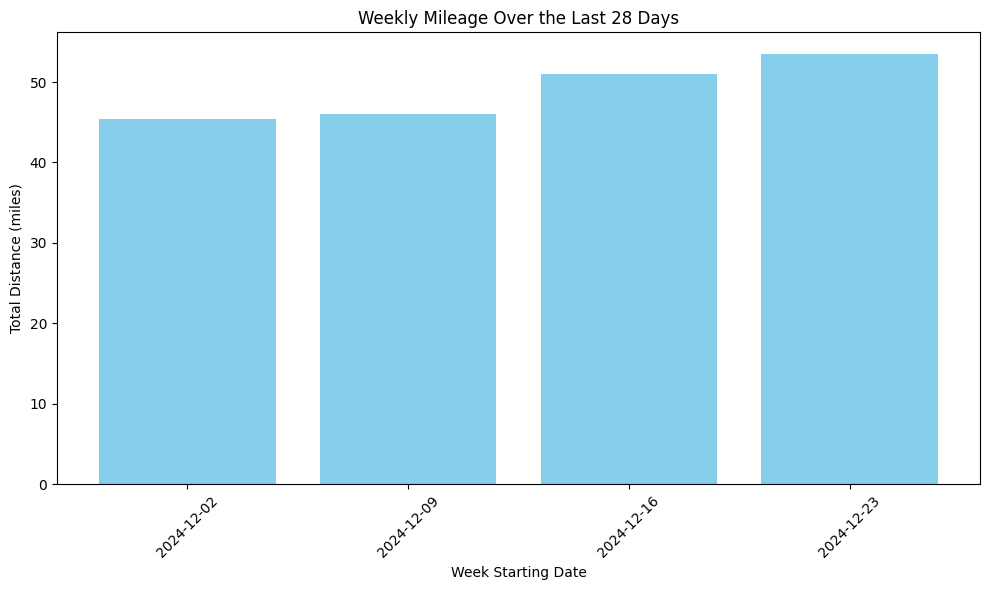

  Week Start  Distance
0 2024-12-02     45.40
1 2024-12-09     46.04
2 2024-12-16     50.98
3 2024-12-23     53.50


In [62]:
# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]


# Assuming you have the function to filter the last N days
# Use your existing function to filter for the last 28 days
last_28_days = filter_last_days(df, 27)

# Ensure that you work with a copy of the DataFrame
last_28_days = last_28_days.copy()

# Use .loc[] to safely assign a new column in the DataFrame
last_28_days.loc[:, 'Week Start'] = last_28_days['Date'] - pd.to_timedelta(last_28_days['Date'].apply(lambda x: pd.Timestamp(x).weekday()), unit='D')

# Group by 'Week Start' and sum the distance for each week
weekly_mileage = last_28_days.groupby('Week Start')['Distance'].sum().reset_index()

# Plotting the weekly mileage as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekly_mileage['Week Start'].astype(str), weekly_mileage['Distance'], color='skyblue')
plt.xlabel('Week Starting Date')
plt.ylabel('Total Distance (miles)')
plt.title('Weekly Mileage Over the Last 28 Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, print the weekly mileage data for review
print(weekly_mileage)


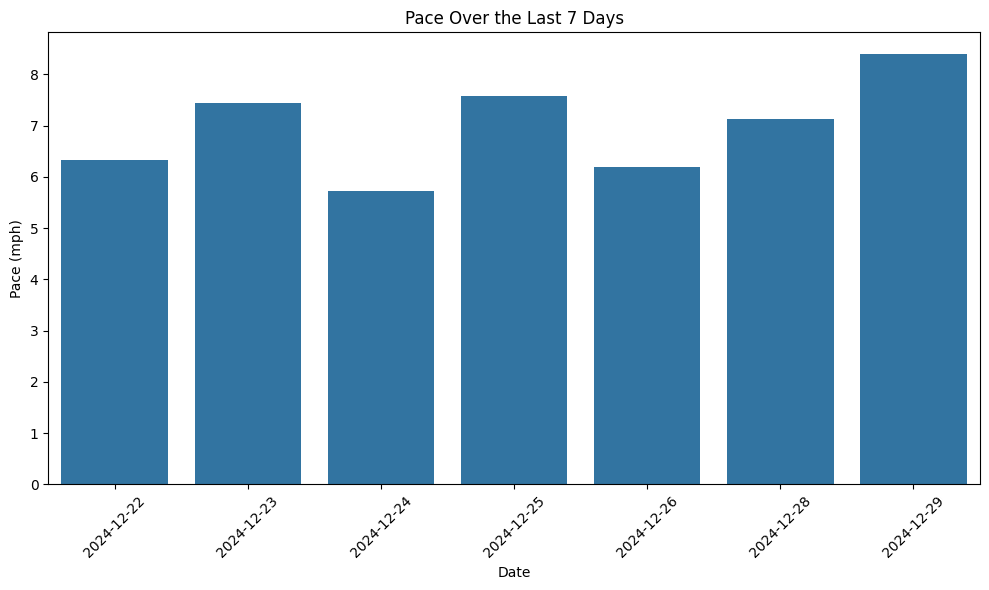

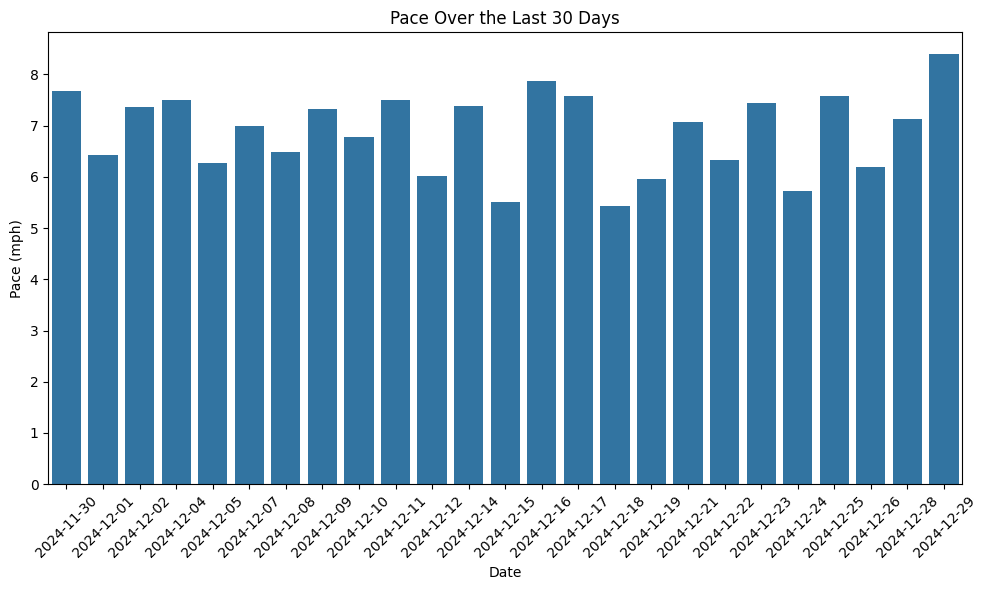

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to filter data for the last X days
def filter_last_days(df, days):
    most_recent_date = df['Date'].max()
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

# Function to plot bar graph for pace over a given period
def plot_pace(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average pace for each day
    daily_pace = last_days.groupby('Date')['Pace (mph)'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Pace (mph)', data=daily_pace)
    plt.title(f'Pace Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Pace (mph)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Plot pace for the last 7, 30, and 90 days
plot_pace(df, 7, "Last 7 Days")
plot_pace(df, 30, "Last 30 Days")




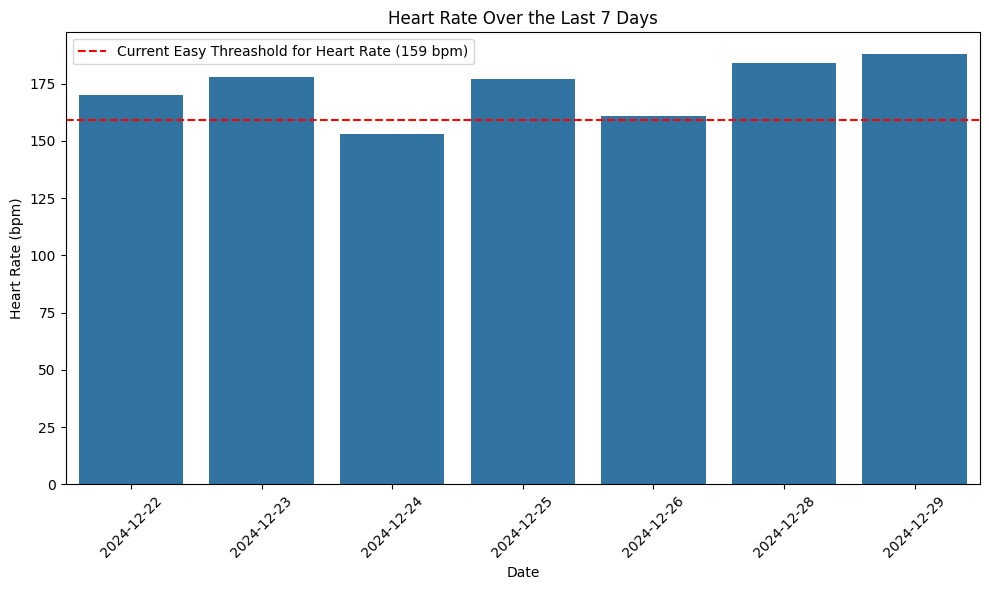

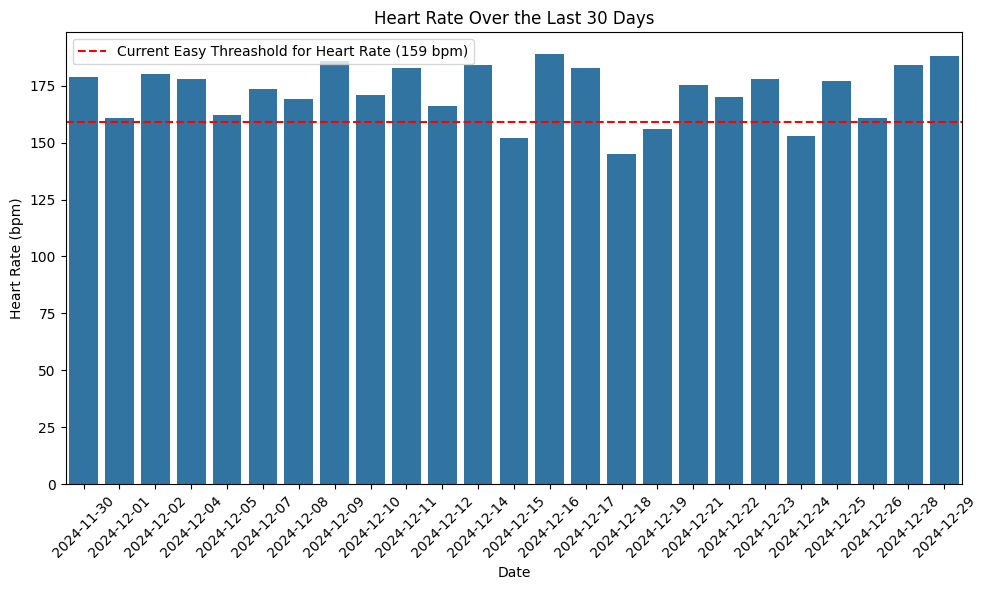

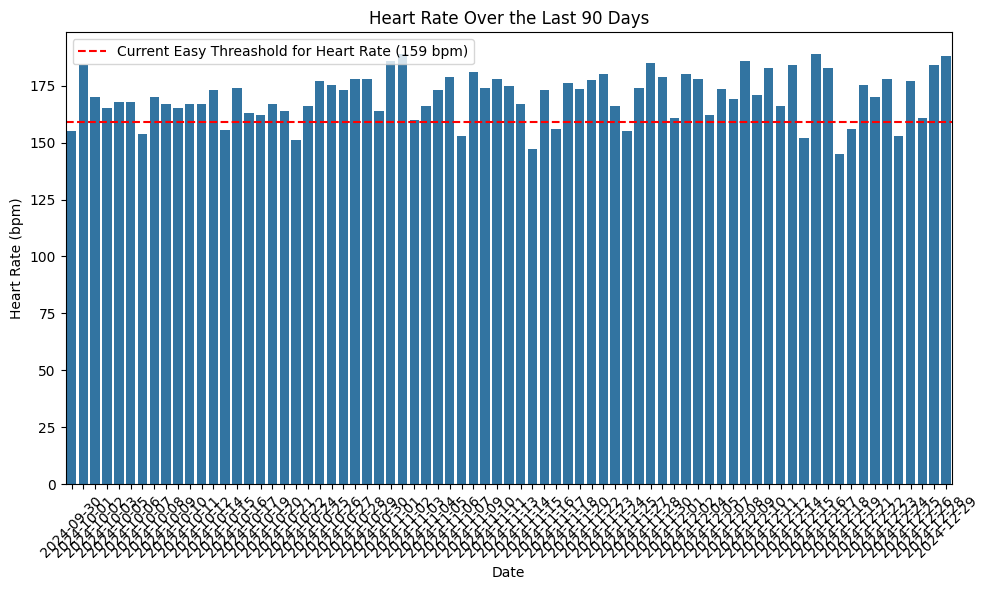

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot bar graph for heart rate over a given period with a horizontal line at 155 bpm
def plot_heart_rate(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average heart rate for each day
    daily_heart_rate = last_days.groupby('Date')['Heart Rate'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Heart Rate', data=daily_heart_rate)
    
    # Add a horizontal line at y=155 bpm
    plt.axhline(y=159, color='r', linestyle='--', label='Current Easy Threashold for Heart Rate (159 bpm)')
    
    plt.title(f'Heart Rate Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Heart Rate (bpm)')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

# Plot heart rate for the last 7, 30, and 90 days
plot_heart_rate(df, 7, "Last 7 Days")
plot_heart_rate(df, 30, "Last 30 Days")
plot_heart_rate(df, 90, "Last 90 Days")



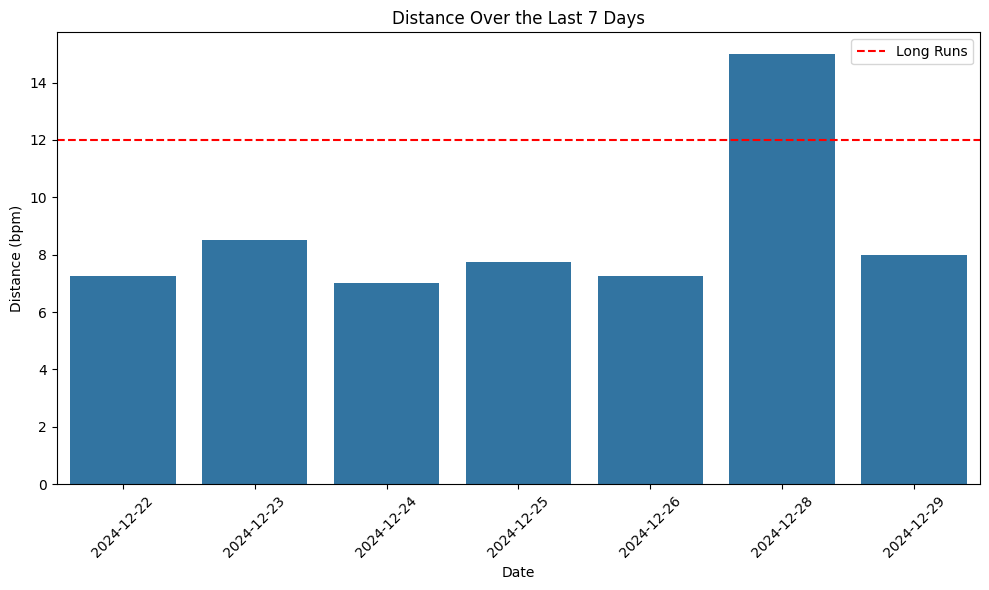

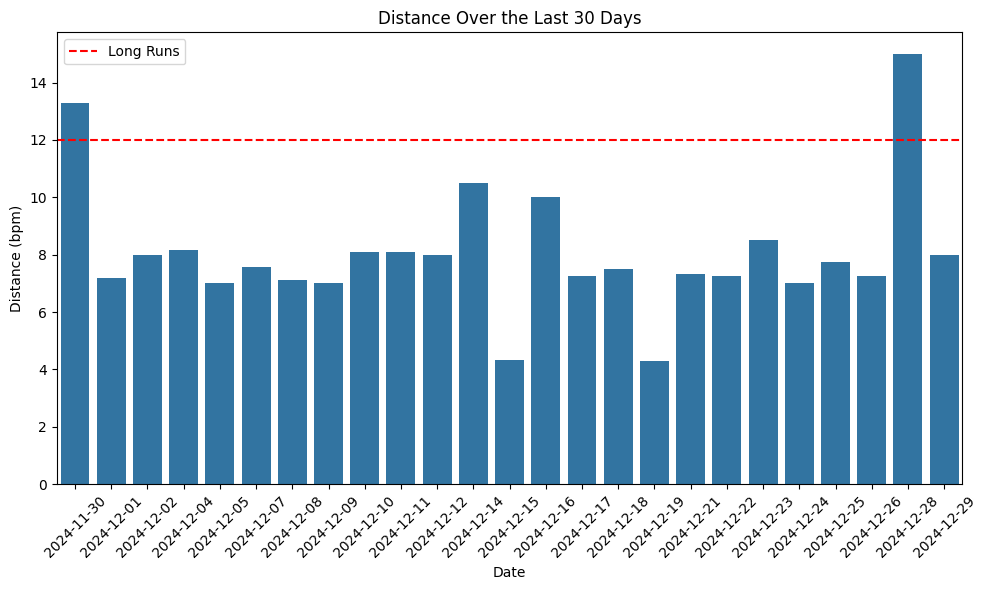

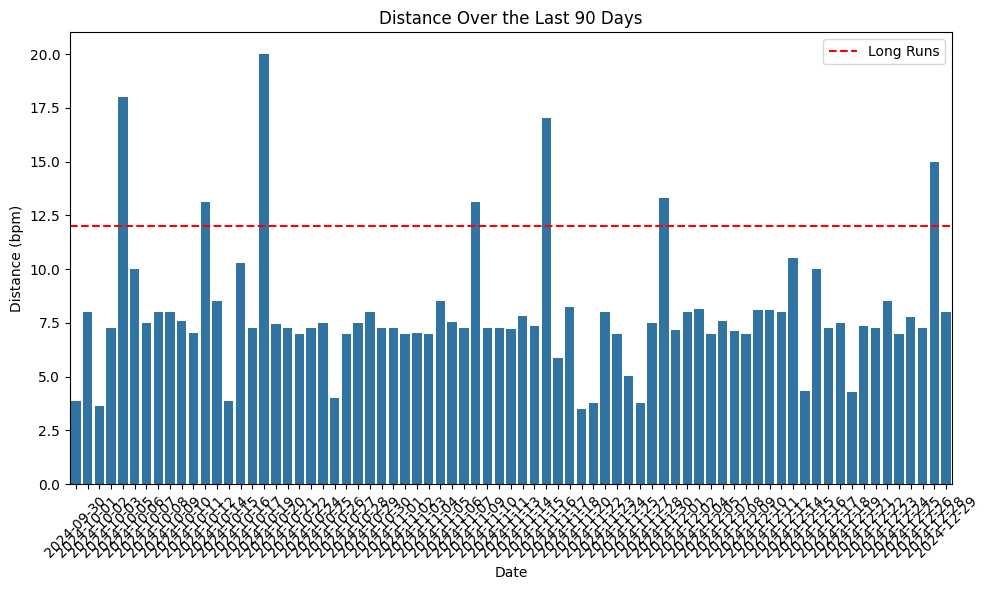

In [65]:
# Function to plot bar graph for heart rate over a given period with a horizontal line at 155 bpm
def plot_distance_rate(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average heart rate for each day
    daily_distance_rate = last_days.groupby('Date')['Distance'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Distance', data=daily_distance_rate)
    
    # Add a horizontal line at y=155 bpm
    plt.axhline(y= 12, color='r', linestyle='--', label='Long Runs')
    
    plt.title(f'Distance Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Distance (bpm)')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

# Plot heart rate for the last 7, 30, and 90 days
plot_distance_rate(df, 7, "Last 7 Days")
plot_distance_rate(df, 30, "Last 30 Days")
plot_distance_rate(df, 90, "Last 90 Days")



In [66]:
# import matplotlib.pyplot as plt

# # Calculate and display correlation for the last 7 days
# correlation_7_days = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 7 days: {correlation_7_days:.2f}")

# # Calculate and display correlation for the last 30 days
# correlation_30_days = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 30 days: {correlation_30_days:.2f}")

# # Calculate and display correlation for the last 90 days
# correlation_90_days = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 90 days: {correlation_90_days:.2f}")
 
# # Scatter Plot: Pace vs Heart Rate for the Last 7 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_7_days)
# plt.correlation = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 7 Days\nCorrelation: {correlation_7_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_30_days)
# plt.correlation = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 30 Days\nCorrelation: {correlation_30_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_90_days)
# plt.correlation = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 90 Days\nCorrelation: {correlation_90_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate performance score
def calculate_performance_score(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0:
        return None  # Handle division by zero

    performance_score = (
        (pace ** 1.9)          # Heavily reward faster paces
        * ((distance ** 1) / 1.3)  # Strongly reward longer distances
        / (heart_rate ** 0.31)  # Minimally penalize higher heart rate
    )
    return performance_score

# Function to plot performance score over a given period with a horizontal line
def plot_performance_score(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Apply the performance score function to the filtered data
    last_days.loc[:, 'Performance Score'] = last_days.apply(
        lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1
    )
    
    # Group by date and calculate the average performance score for each day
    daily_performance_score = last_days.groupby('Date')['Performance Score'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Performance Score', data=daily_performance_score)
    
    # Add a horizontal line for a certain threshold (adjust threshold as needed)
    plt.axhline(y=50, color='r', linestyle='--', label='Performance Threshold')
    
    plt.title(f'Performance Score Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

# # Example usage:
# # Plot performance score for the last 7, 30, and 90 days
# plot_performance_score(df, 7, "Last 7 Days")
# plot_performance_score(df, 30, "Last 30 Days")
# plot_performance_score(df, 90, "Last 90 Days")


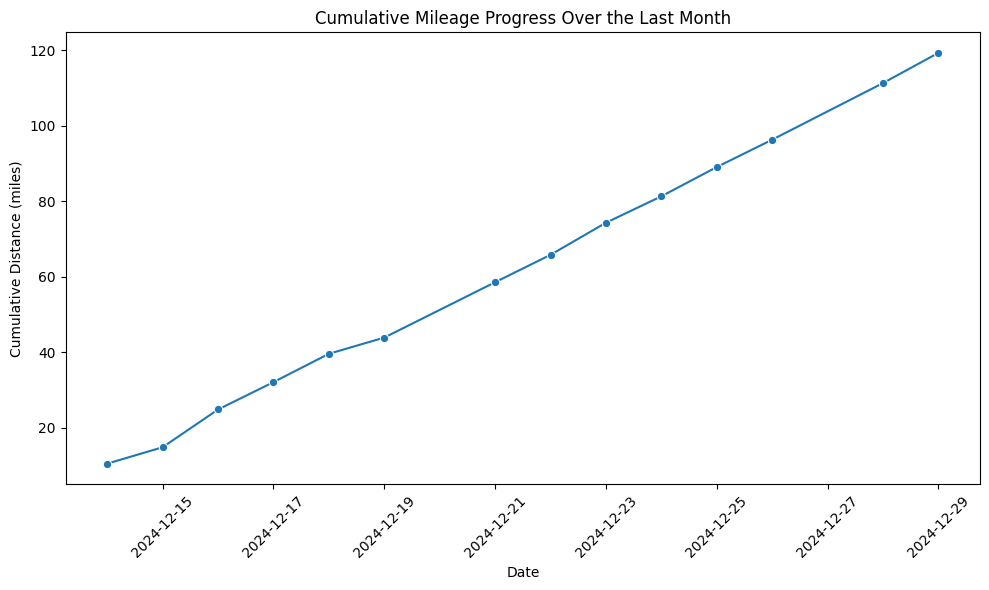

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 3 months
three_months_ago = pd.to_datetime('today') - pd.DateOffset(months=1)
df_last_3_months = df[df['Date'] >= three_months_ago]

# Group by date and sum the distance for each day
daily_mileage = df_last_3_months.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage over the last 3 months
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.title('Cumulative Mileage Progress Over the Last Month')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

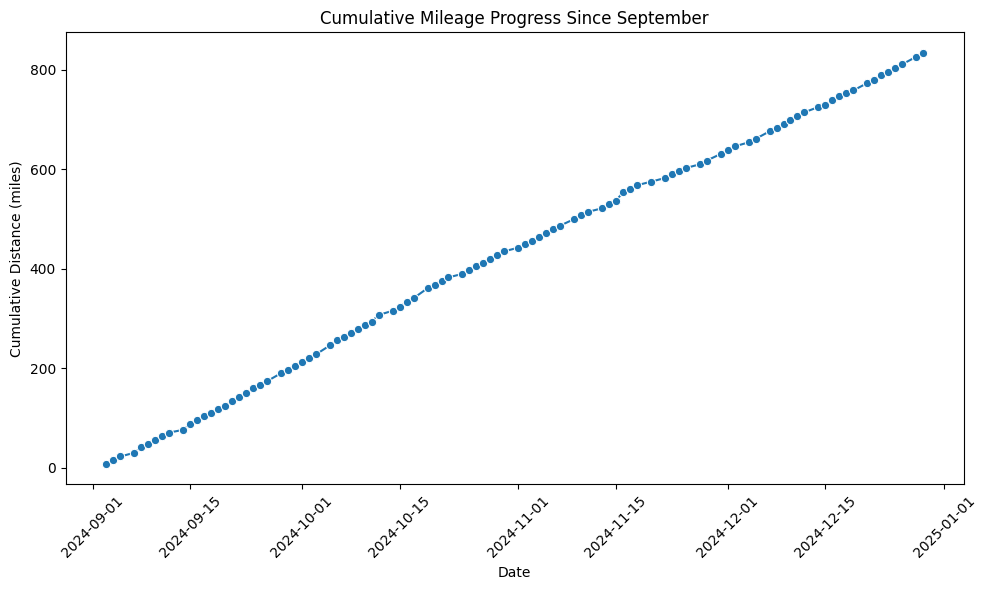

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data since September
september_start = pd.to_datetime('2024-09-01')  # Adjust this to the start date of September
df_since_september = df[df['Date'] >= september_start]

# Group by date and sum the distance for each day
daily_mileage = df_since_september.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage since September
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.title('Cumulative Mileage Progress Since September')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


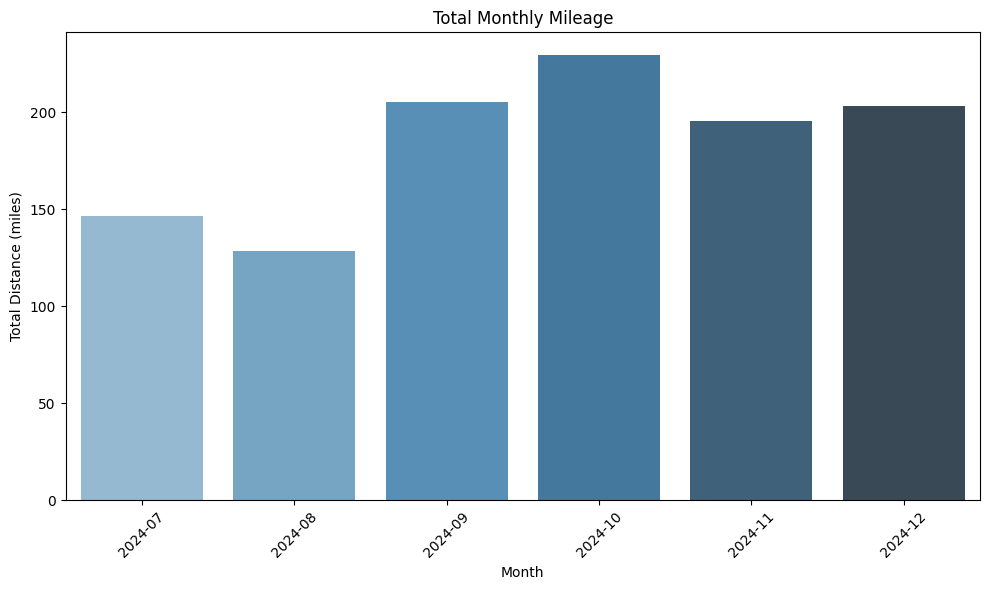

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in string format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert 'Date' to datetime

# Filter data for the past 6 months, starting from July 1st
start_of_july = pd.to_datetime('2024-07-01')  # Set the start date to July 1st, 2024
df_last_6_months = df[df['Date'] >= start_of_july].copy()  # Use .copy() to avoid modifying the slice

# Now, use .loc to avoid the SettingWithCopyWarning
df_last_6_months.loc[:, 'Year-Month'] = df_last_6_months['Date'].dt.to_period('M')

# Group by 'Year-Month' and sum the distance for each month
monthly_mileage = df_last_6_months.groupby('Year-Month')['Distance'].sum().reset_index()

# Sort by 'Year-Month'
monthly_mileage = monthly_mileage.sort_values('Year-Month')

# Plotting the monthly mileage bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage, hue='Year-Month', palette='Blues_d', legend=False)
plt.title('Total Monthly Mileage')
plt.xlabel('Month')
plt.ylabel('Total Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Training Stress Score (TSS)
The TSS is a score used to quantify the intensity and duration of a workout, taking into account both the duration and the intensity of the workout. The formula for TSS is:

𝑇𝑆𝑆 = (Duration × Intensity Factor (IF) / FTP) × 100

Where:

Duration is the time of the workout (in hours or minutes).

Intensity Factor (IF) is calculated as the ratio of normalized power to functional threshold power (FTP) or normalized pace to threshold pace.

FTP is your Functional Threshold Power or your threshold pace. If you're a runner, FTP could be your threshold pace (pace at which you can run for about an hour).

## Acute Training Load (ATL) and Chronic Training Load (CTL)
These values measure the impact of your recent and long-term training loads.

ATL (Acute Training Load): This is the 7-day rolling average of TSS. It gives an idea of how hard your recent workouts have been.

CTL (Chronic Training Load): This is the 28-day rolling average of TSS, reflecting your long-term fitness and how consistent your training has been.

/tmp/ipykernel_53024/3148209556.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']
/tmp/ipykernel_53024/3148209556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)
/tmp/ipykernel_53024/3148209556.py:22: SettingWithCopyWarning: 
A value is trying to be set on a

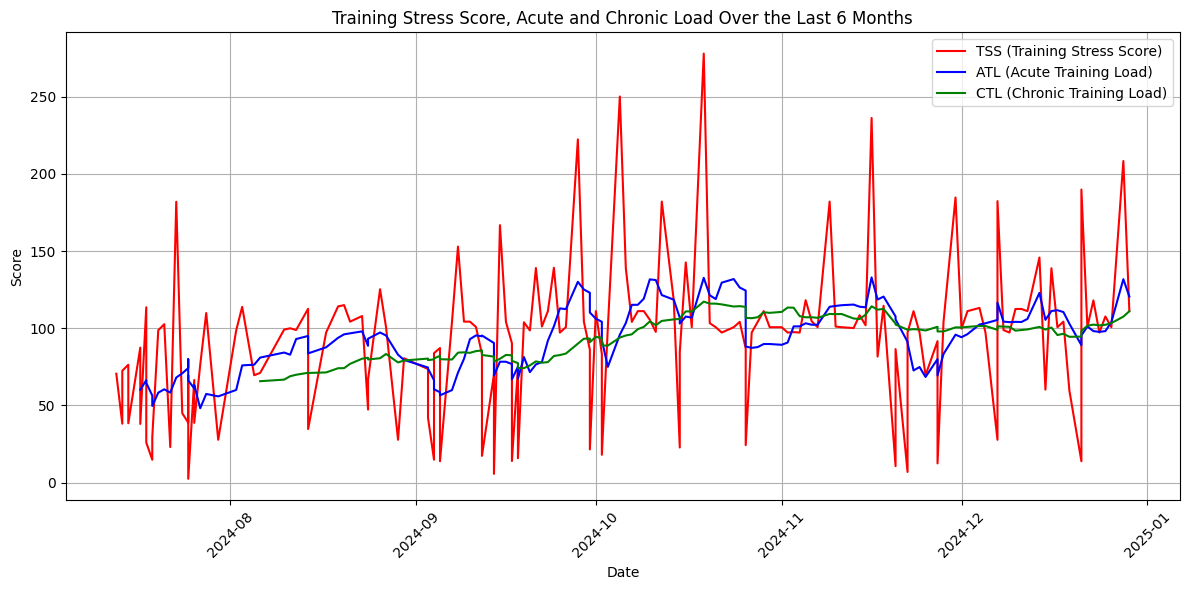

        Date         TSS         ATL         CTL
4 2024-12-24   97.222222   97.678571  101.889881
3 2024-12-25  107.638889   98.154762  102.261905
2 2024-12-26  100.694444  104.027778  103.373016
1 2024-12-28  208.333333  131.805556  107.539683
0 2024-12-29  111.111111  120.555556  111.061508


In [71]:
# Assuming you already have a dataframe df with 'Date', 'Distance', 'Pace (mph)', 'Heart Rate'
# You can add your threshold pace value (FTP) here
threshold_pace = 7.2  # e.g., threshold pace of 6 mph (adjust according to your actual pace)

# Filter the data to include only the last 6 months
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=6)
df_last_6_months = df[df['Date'] >= six_months_ago]

# Function to calculate TSS (Training Stress Score)
def calculate_tss(distance, pace, duration, threshold_pace):
    intensity_factor = pace / threshold_pace  # Calculate intensity factor based on pace
    tss = (duration * intensity_factor) * 100  # TSS formula
    return tss

# Calculate Duration (time in hours) for each row in the dataframe
df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']

# Calculate TSS for each run
df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)

# Calculate the 7-day (ATL) and 28-day (CTL) rolling averages of TSS
df_last_6_months['ATL'] = df_last_6_months['TSS'].rolling(window=7).mean()
df_last_6_months['CTL'] = df_last_6_months['TSS'].rolling(window=28).mean()

# Plot the TSS, ATL, and CTL over time for the last 6 months
plt.figure(figsize=(12, 6))

plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS (Training Stress Score)', color='red')
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL'], label='ATL (Acute Training Load)', color='blue')
plt.plot(df_last_6_months['Date'], df_last_6_months['CTL'], label='CTL (Chronic Training Load)', color='green')

plt.title('Training Stress Score, Acute and Chronic Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Optionally, print the TSS, ATL, and CTL for review
print(df_last_6_months[['Date', 'TSS', 'ATL', 'CTL']].tail())

/tmp/ipykernel_53024/1292237650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()


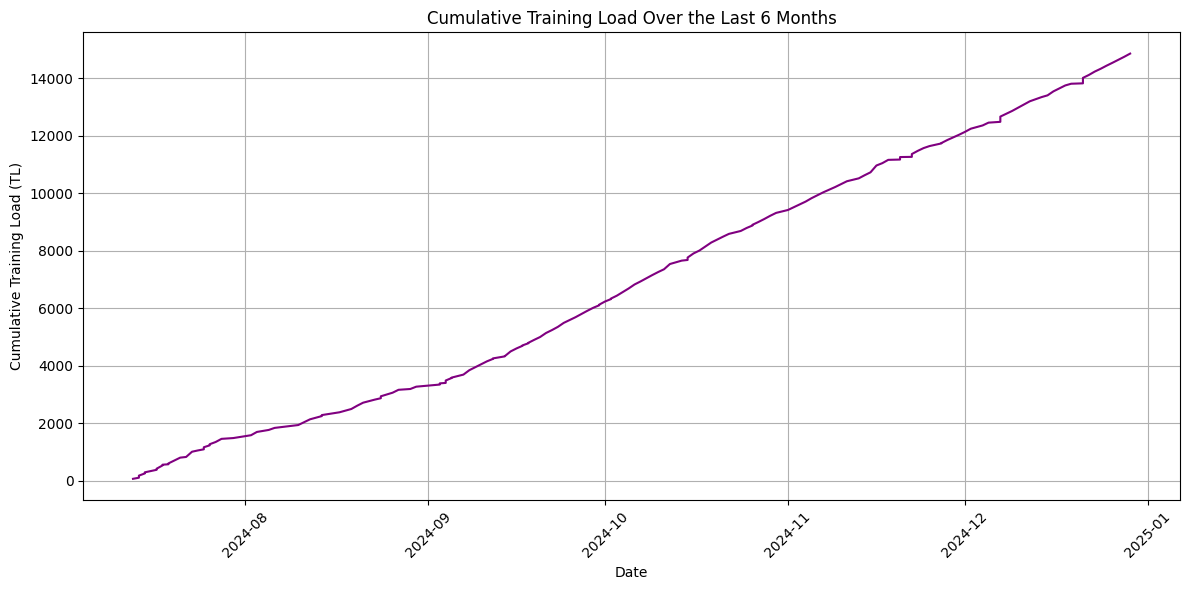

In [72]:
# Calculate cumulative training load (sum of TSS values)
df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()

# Plot Cumulative Training Load
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Cumulative TL'], label='Cumulative Training Load', color='purple')
plt.title('Cumulative Training Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Training Load (TL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Intensity Factor (IF):
Intensity factor is used to express the intensity of a workout relative to your threshold. It can be a more specific measure of how hard the workout was in relation to your capability. For running, it's typically calculated as:

𝐼𝐹 = Actual Pace / Threshold Pace
​
This could give you a clear view of how much you are pushing yourself in relation to your usual running capability.

/tmp/ipykernel_53024/3364448182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace


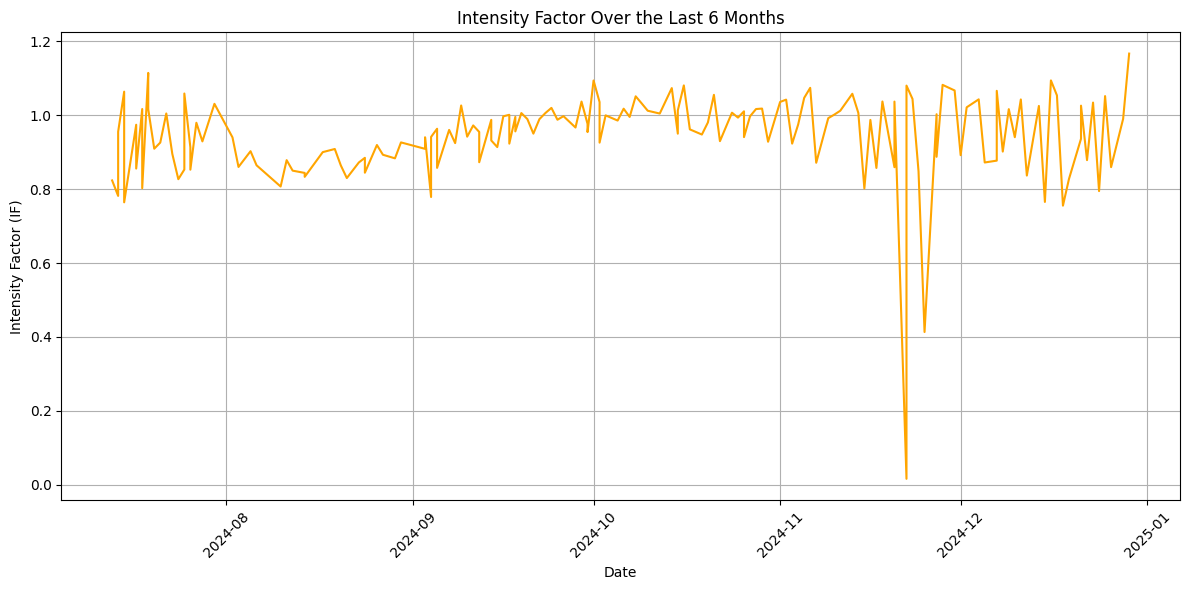

In [73]:
threshold_pace = 7.2

# Calculate Intensity Factor (IF)
df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace

# Plot IF over time
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Intensity Factor'], label='Intensity Factor (IF)', color='orange')
plt.title('Intensity Factor Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Intensity Factor (IF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Acute vs Chronic Load Comparison: 
You can plot a difference between Acute Load (ATL) and Chronic Load (CTL) over time to identify periods of overtraining or recovery needs. If ATL significantly exceeds CTL, it might indicate that you are pushing yourself too hard recently.

/tmp/ipykernel_53024/2503842443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['ATL - CTL Difference'] = df_last_6_months['ATL'] - df_last_6_months['CTL']


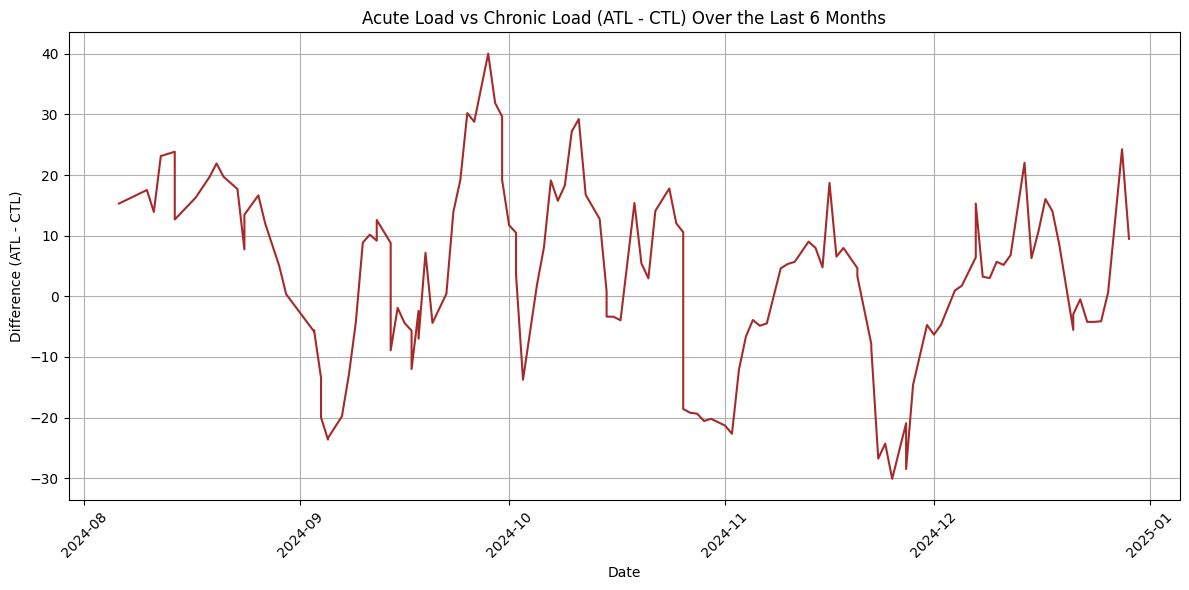

In [74]:
# Calculate ATL - CTL difference
df_last_6_months['ATL - CTL Difference'] = df_last_6_months['ATL'] - df_last_6_months['CTL']

# Plot ATL vs CTL difference
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL - CTL Difference'], label='ATL - CTL Difference', color='brown')
plt.title('Acute Load vs Chronic Load (ATL - CTL) Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Difference (ATL - CTL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Training Peaks: 
Peaks will help you spot high-intensity sessions that may require more recovery.

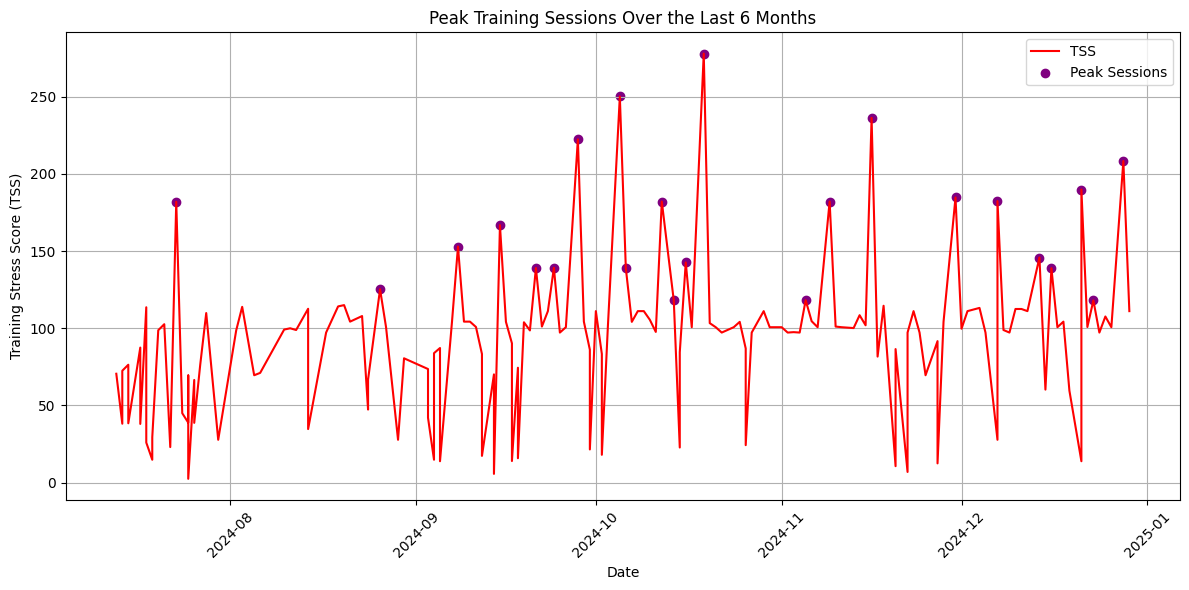

          Date                                     Title         TSS  \
144 2024-07-23                                  Ahh shit  181.944444   
118 2024-08-26                                 intervals  125.277778   
107 2024-09-08                                  Long Run  152.916667   
99  2024-09-15                                  Long run  166.805556   
91  2024-09-21                                  Long Run  139.027778   
88  2024-09-24                            I got the worm  139.166667   
85  2024-09-28                                Psychotron  222.361111   
77  2024-10-05                                 Get Lucky  250.138889   
76  2024-10-06                    Foreclosure of A Dream  138.888889   
70  2024-10-12                   Give Life Back To Music  182.083333   
69  2024-10-14                                  SMUCKERS  118.055556   
66  2024-10-16  Err, like hop, I hopped out like wassup?  142.638889   
64  2024-10-19                                  GINOBILI  277.91

In [75]:
# Define a threshold for peak training sessions (e.g., TSS > 100)
peak_sessions = df_last_6_months[df_last_6_months['TSS'] > 115]

# Plot peak sessions
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS', color='red')
plt.scatter(peak_sessions['Date'], peak_sessions['TSS'], color='purple', label='Peak Sessions')
plt.title('Peak Training Sessions Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Training Stress Score (TSS)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

print(peak_sessions[['Date', 'Title','TSS', 'Distance', 'Pace (mph)', 'Heart Rate']])

## Stress/Rest Ratio
This can be calculated as the ratio of the acute load (ATL) to chronic load (CTL). It provides an indication of how well-balanced your training and recovery are. A high ATL/CTL ratio might indicate you're not recovering enough and could be at risk for overtraining.

/tmp/ipykernel_53024/593534801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']


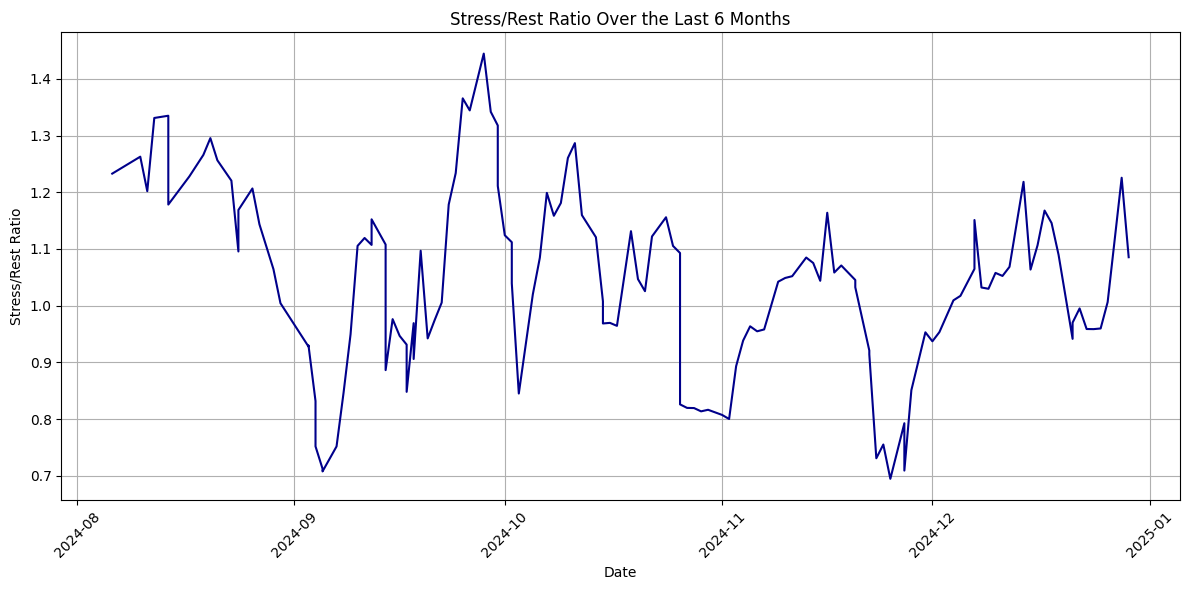

In [76]:
# Calculate Stress/Rest ratio
df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']

# Plot Stress/Rest Ratio
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Stress/Rest Ratio'], label='Stress/Rest Ratio', color='darkblue')
plt.title('Stress/Rest Ratio Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Stress/Rest Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


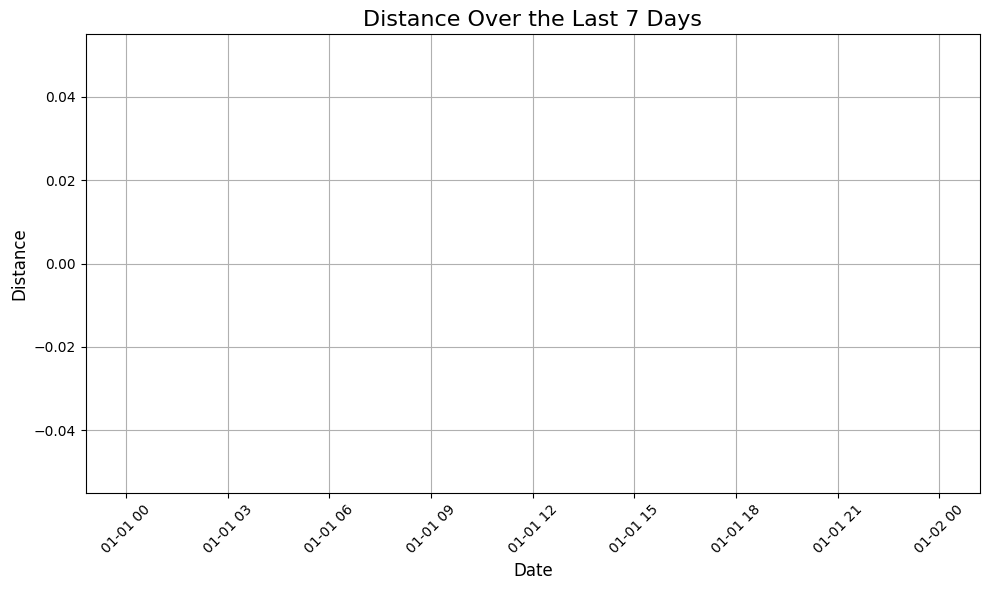

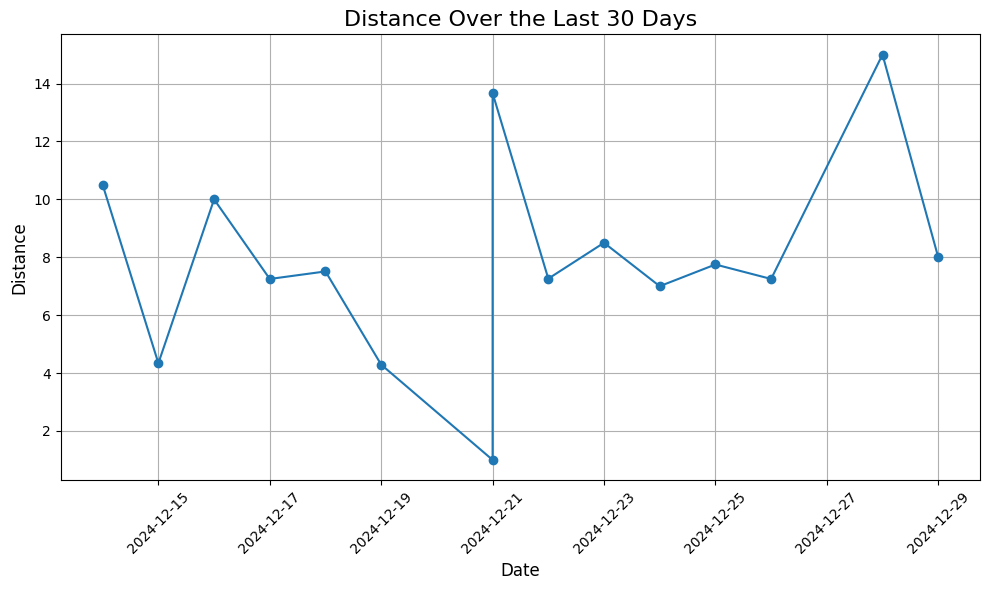

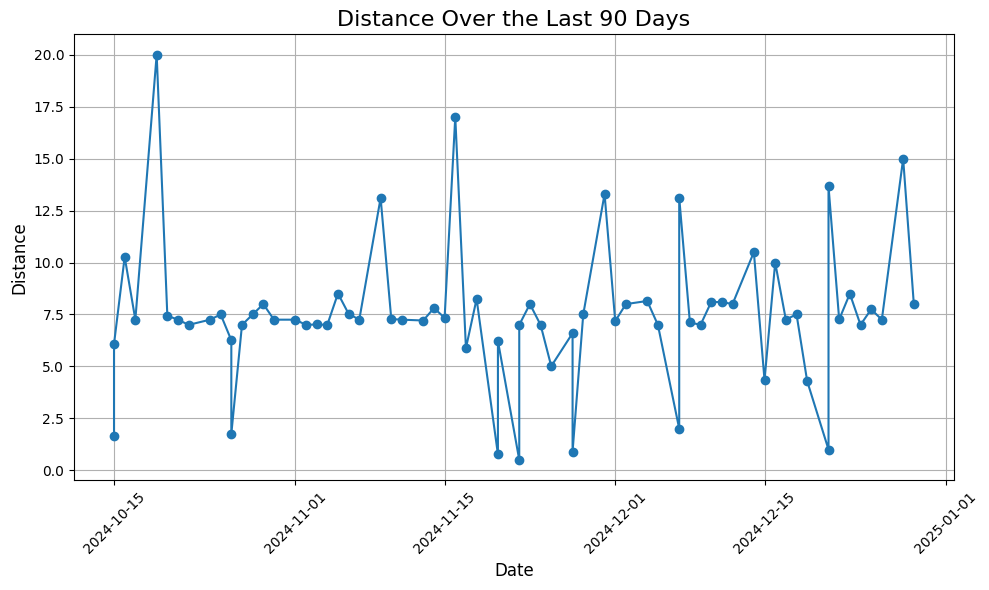

In [77]:
# Plot distances for a given period
def plot_distance(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], data['Distance'], marker='o', linestyle='-')
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function for each period
plot_distance(last_7_days, "Distance Over the Last 7 Days")
plot_distance(last_30_days, "Distance Over the Last 30 Days")
plot_distance(last_90_days, "Distance Over the Last 90 Days")